# Gradient Boosting Trees 

## Import Libraries

In [13]:
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline

I'll bring back my wrangle function from the data exploration phase

In [3]:
def wrangle(filepath):
    # read csv into DataFrame
    df = pd.read_csv(filepath)
    
    # Rename columns for better clarity and to facilitate analysis
    df.rename(columns={'Age in 5-year groups': 'age',
                       'Type of place of residence': 'residence',
                       'Highest educational level': 'educational_level',
                       'Wealth index combined': 'wealth_index',
                       'Births in last five years': 'births_5_years',
                       'Age of respondent at 1st birth': 'respondent_1st_birth',
                       'Hemoglobin level adjusted for altitude and smoking (g/dl - 1 decimal)': 'hemoglobin_altitude_smoking',
                       'Anemia level': 'anemia_level_target',
                       'Have mosquito bed net for sleeping (from household questionnaire)': 'mosquito_net_owners',
                       'Smokes cigarettes': 'smokers',
                       'Current marital status': 'marital_status',
                       'Currently residing with husband/partner': 'partner_residence',
                       'When child put to breast': 'child_put_breast',
                       'Had fever in last two weeks': 'fever_two_weeks',
                       'Hemoglobin level adjusted for altitude (g/dl - 1 decimal)': 'hemoglobin_altitude',
                       'Anemia level.1': 'anemia_level_1',
                       'Taking iron pills, sprinkles or syrup': 'iron_pills'}, inplace=True)
    
    # drop collumn with 50% null values .
    df.drop(columns="anemia_level_1" , inplace = True)
    
    # List of columns to impute
    columns_to_impute = ['hemoglobin_altitude_smoking','hemoglobin_altitude']

    # Convert relevant columns to numeric before imputing
    numeric_columns = columns_to_impute
    for column in numeric_columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    # Impute missing values with mean
    for column in columns_to_impute:
        mean_value = df[column].mean()
        df[column].fillna(mean_value, inplace=True)
        
    # drop the column for high cardinality
    df.drop(columns="child_put_breast", inplace=True)  
    
    # Fill NaN values in specified columns with the string "Dont know"
    df['anemia_level_target'] = df['anemia_level_target'].fillna("Dont know") 
    
    #'Anemia level'  mapping
    category_mapping = {'Dont know': 0, 'Moderate': 1, 'Mild': 2, 'Not anemic': 3, 'Severe': 4}

    # Map the categories to numerical values
    df['anemia_level_target'] = df['anemia_level_target'].map(category_mapping)
    
    
    # define a function
    def replace_nan_with_word(x, word='Staying elsewhere'):
        """
        Replace NaN values in a pandas Series with a specified word.

        Parameters:
        - x: pandas Series
        - word: str, default='Staying elsewhere'
        """
        return x.fillna(word)

    # Apply the function to replace NaN values in the column
    df['partner_residence'] = replace_nan_with_word(df['partner_residence'])

    # Fill NaN values in the 'fever_two_weeks' column with the string "Dont know"
    df['fever_two_weeks'] = df['fever_two_weeks'].fillna("Dont know")
    
    # Fill NaN values in the 'iron_pills' column with the string "Dont know"
    df['iron_pills'] = df['iron_pills'].fillna("Dont know")
    

    return df

In [4]:
df = wrangle("children anemia.csv")
df.head()

,age,residence,educational_level,wealth_index,births_5_years,respondent_1st_birth,hemoglobin_altitude_smoking,anemia_level_target,mosquito_net_owners,smokers,marital_status,partner_residence,fever_two_weeks,hemoglobin_altitude,iron_pills
0,40-44,Urban,Higher,Richest,1,22,114.367235,0,Yes,No,Living with partner,Staying elsewhere,No,101.270183,Yes
1,35-39,Urban,Higher,Richest,1,28,114.367235,0,Yes,No,Married,Living with her,No,101.270183,No
2,25-29,Urban,Higher,Richest,1,26,114.367235,0,No,No,Married,Living with her,No,101.270183,No
3,25-29,Urban,Secondary,Richest,1,25,95.000000,1,Yes,No,Married,Living with her,No,114.000000,No
4,20-24,Urban,Secondary,Richest,1,21,114.367235,0,Yes,No,No longer living together/separated,Staying elsewhere,No,101.270183,No


## Split

I'll Create my feature matrix X and target vector y. My target is "anemia_level_target"

In [5]:
# create feature and target .
target = "anemia_level_target"
X = df.drop(columns=target)
y = df[target]

I'll now use a randomized train-test split to divide my data (X and Y) into training and test sets. 20% of my entire data are in my test set. Next, to ensure reproducibility, I'll set a random state.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (27139, 14)
y_train shape: (27139,)
X_test shape: (6785, 14)
y_test shape: (6785,)


## Build Model

### Baseline

Calculate the baseline accuracy score for my model.

In [8]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.61


Now I'll Create a pipeline named clf (short for "classifier") that contains a GradientBoostingClassifier predictor.

In [9]:
clf = GradientBoostingClassifier(random_state=42)
print(clf)

GradientBoostingClassifier(random_state=42)


Next, I am going to tune some of the hyperparameters for my model.

In [10]:
# Create a dictionary with the range of hyperparameters that we want to evaluate for our classifier
params = {
    "n_estimators": range(20,31,5),
    "max_depth":  range(2,5)
}
params

{'n_estimators': range(20, 31, 5), 'max_depth': range(2, 5)}

Next I'll Create a GridSearchCV named model that includes my classifier and hyperparameter grid.

In [15]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Create a column transformer for automatic one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
        ('num', SimpleImputer(strategy='mean'), X_train.columns.difference(categorical_columns))
    ],
    remainder='passthrough'  
)

# Create a pipeline with preprocessing and the classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Define the parameter grid for grid search
params = {
    'classifier__max_depth': range(2, 5),
    'classifier__n_estimators': range(20, 31, 5)
}

# Create the GridSearchCV object
model = GridSearchCV(
    pipeline,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)


Now i'll fit the model to my data 


In [16]:
# Fit model to over-sampled training data
model.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['age', 'residence', 'educational_level', 'wealth_index',
       'mosquito_net_owners', 'smokers', 'marital_status', 'partner_residence',
       'fever_two_weeks', 'iron_pills'],
      dtype='object')),
                                                                        ('num',
                                                                         SimpleImputer(),
                                                                         Index(['births_5_years', 'hemoglobin_altitude', 'hemoglobin_altitude_smoking',
       'respondent_1st_birth'],
      dtype='

Inspect the hyperparameters that led to the best performance.

In [17]:
# Extract best hyperparameters
best_model_par = model.best_params_
model_best_score = model.best_score_

print(f" the best model paramters is : {best_model_par}")
print(f" the model best score is : {model_best_score}")

 the best model paramters is : {'classifier__max_depth': 2, 'classifier__n_estimators': 25}
 the model best score is : 0.9740226988097804


## Evaluate

In [18]:
# Calculate the accuracy score for my model 
acc_train =  model.score(X_train,y_train)
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Validation Accuracy:", round(acc_test, 4))

Training Accuracy: 0.9741
Validation Accuracy: 0.9721


I'll create a confusion matrix to see how my model is making its correct and incorrect predictions.

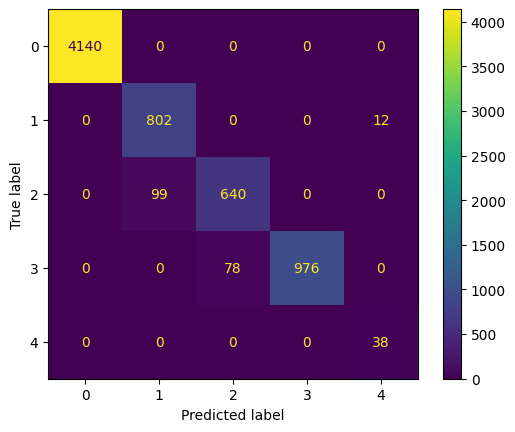

In [19]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(model,X_test,y_test);

Next I'll Print the classification report for my model, using the test set.

In [23]:
# Print classification report
print(classification_report(y_test,model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4140
           1       0.89      0.99      0.94       814
           2       0.89      0.87      0.88       739
           3       1.00      0.93      0.96      1054
           4       0.76      1.00      0.86        38

    accuracy                           0.97      6785
   macro avg       0.91      0.96      0.93      6785
weighted avg       0.97      0.97      0.97      6785

